In [1]:
from reader_utils.corpus_builder_utils import *
from note_utils.pitch_dictionary import PitchDictionary
from reader_utils.dataset_builder import DatasetBuilder
from model_utils.model_utils import *
from gensim.models import Word2Vec

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import random
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
def cosine_similarity(v1, v2):
    denominator = np.linalg.norm(v1) * np.linalg.norm(v2)
    if np.isclose(denominator, 0, atol=1e-32):
        return 0
    return np.dot(v1, v2) / denominator

In [27]:
def analogy(model, x1, x2, y1):
    result = model.wv.most_similar(positive=[y1, x2], negative=[x1], topn=3)
    return result

In [3]:
pd = PitchDictionary("dataset_objects/pitches_dict.txt")
db = DatasetBuilder("dataset_objects/full_corpus")

In [4]:
raw_corpus_path = "dataset_objects/raw_full_corpus"
raw_corpus = db.read_corpus_from_path(raw_corpus_path)

In [5]:
model = Word2Vec(sentences=raw_corpus, vector_size=50, window=5, min_count=1, negative=5, epochs=10)

In [6]:
mod_sim = model.wv.similarity("la4", "sol4")
v1 = model.wv["la4"]
v2 = model.wv["sol4"]
co_sim = cosine_similarity(v1, v2)
print(mod_sim, co_sim)

0.60250914 0.60250926


In [41]:
# most_similar(positive=['woman', 'king'], negative=['man']) 
d1 = model.wv["sol4"] + model.wv["re5"] - model.wv["la4"]
d2 = model.wv["do5#1"]
print("cos:", cosine_similarity(d1, d2))
print("analogy:", analogy(model, "la4", "mi5", "fa4"))
print("ms:", model.wv.most_similar(positive=["la4", "sol4"], negative=["re5"], topn=3))

cos: 0.39903277
analogy: [('si4b6', 0.5023136734962463), ('sol5#4', 0.40178900957107544), ('fa5', 0.37299758195877075)]
ms: [('re4', 0.6260836124420166), ('mi4', 0.6186834573745728), ('fa4#4', 0.5677913427352905)]


In [8]:
X = [model.wv[x] for x in model.wv.index_to_key]

In [9]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

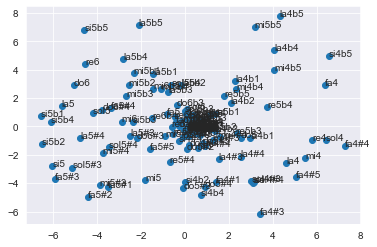

In [10]:
plt.scatter(result[:, 0], result[:, 1])
for i, pitch in enumerate(model.wv.index_to_key):
	plt.annotate(pitch, xy=(result[i, 0], result[i, 1]))

In [11]:
corpus_path_pc = "dataset_objects/raw_full_corpus_pitch_classes"
raw_corpus_pc = db.read_corpus_from_path(corpus_path_pc)

In [12]:
model_pc = Word2Vec(sentences=raw_corpus_pc, vector_size=20, window=10, min_count=100, negative=5, epochs=10)

In [13]:
# most_similar(positive=["woman", "king"], negative=["man"]) => 
# (king – man) + woman = ?    =>    (king – man) = ? - woman
model_pc.wv.most_similar(positive=["re", "sol"], negative=["la"], topn=3)

[('es', 0.25718581676483154),
 ('mib4', 0.2162587195634842),
 ('la#4', 0.20824679732322693)]

In [14]:
num_dimensions = 2  # final num dimensions (2D, 3D, etc)

# extract the words & their vectors, as numpy arrays
vectors = np.asarray(model_pc.wv.vectors)
labels = np.asarray(model_pc.wv.index_to_key)  # fixed-width numpy strings

# reduce using t-SNE
tsne = TSNE(n_components=num_dimensions, random_state=0)
vectors = tsne.fit_transform(vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]

/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ihp/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


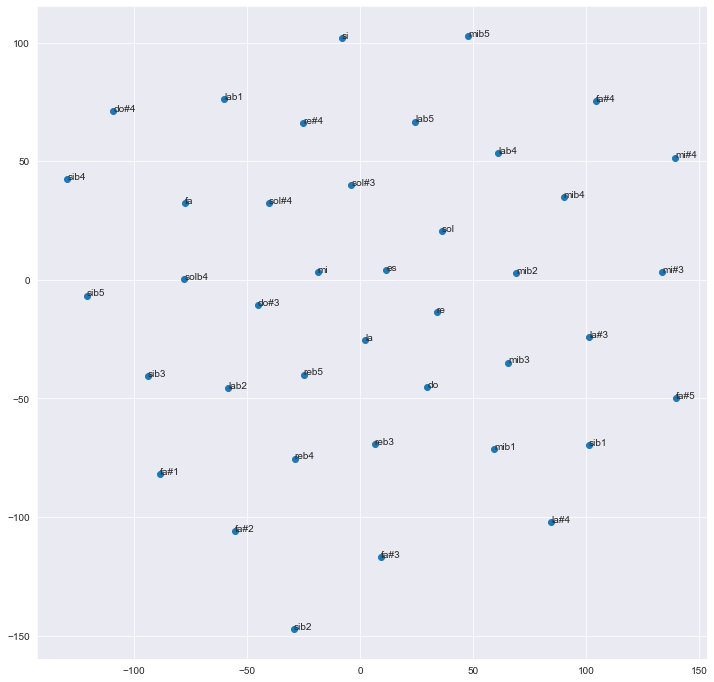

In [15]:
plt.figure(figsize=(12, 12))
plt.scatter(x_vals, y_vals)

for i in range(len(labels)):
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
